Explanation for the code:

This code is divided into two models: Decision Tree and Random Forest.

For each, it starts with pre hyperpara tuning prediction, then it tunes and rerun the model with tuned parameters. It churns accuracy scores for each step. 

In [1]:
#Read the dataset:
import pandas as pd
df = pd.read_csv('diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

#Format dataset
print('Shape: ', df.shape)
df.head()

Shape:  (70692, 22)


,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


PRE-CLEANING

In [3]:
#Encode the diabetes binary column
from sklearn.preprocessing import LabelEncoder
diabetes_label = LabelEncoder()
df['Diabetes_binary'] = diabetes_label.fit_transform(df['Diabetes_binary']) #dont think this is needed. converts from 0.0 -> 0 and 1.0 -> 1

#Check if the data is balanced
df['Diabetes_binary'].value_counts()


0    35346
1    35346
Name: Diabetes_binary, dtype: int64

<Axes: xlabel='Diabetes_binary', ylabel='count'>

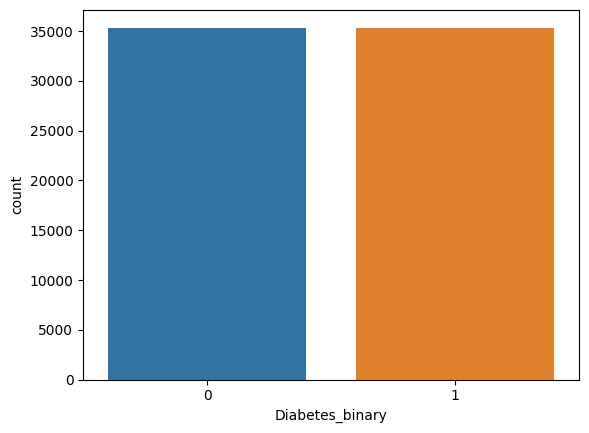

In [4]:
#Visualise data as box plot
import seaborn as sns
sns.countplot(x='Diabetes_binary',data=df)

In [5]:
#Create the train and test sets:
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

from sklearn.model_selection import train_test_split
#Split 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

DECISION TREE

In [7]:
#Build decision tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
clf = DecisionTreeClassifier(random_state=42) # instantiate the model
clf = clf.fit(X_train, y_train) # fit the model

# making predictions
y_pred = clf.predict(X_test) # Test the prediction accurracy of the model
result = pd.DataFrame({'Actual' : y_test, 'Predicted' : y_pred})
pd.concat([result.head(), result.tail()]) # display df of acutal and predicted(head and tail)

,Actual,Predicted
44967,1,1
20220,0,1
23944,0,0
2707,0,0
42356,1,1
59313,1,0
44805,1,0
30661,0,0
30295,0,0
30199,0,1


In [8]:
#Check model's accuracy
from sklearn.metrics import accuracy_score
print('Testing Set Evaluation Accuracy: ',accuracy_score(y_test,y_pred))


Testing Set Evaluation Accuracy:  0.7371101209420751


array([[4921, 2169],
       [1548, 5501]], dtype=int64)

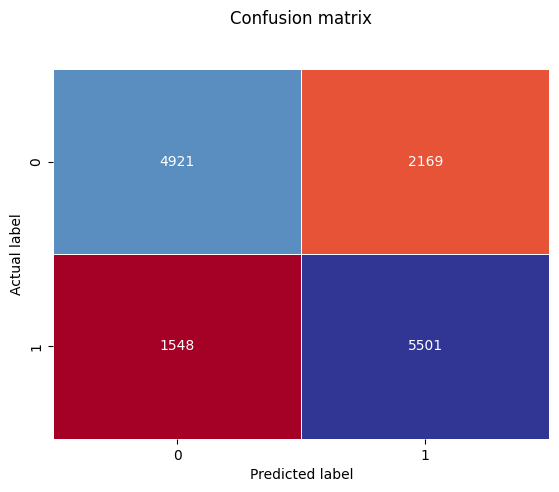

In [9]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
cf_matrix = confusion_matrix(y_test, y_pred) # generate confusion matrix
sns.heatmap(pd.DataFrame(cf_matrix), annot=True, cmap='RdYlBu', linewidth=.5, fmt='g', cbar=False)
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
cf_matrix

In [10]:
#Generate Classification report
from sklearn.metrics import classification_report

target_names = ['Diabete, Yes', 'Diabete, No']
pd.DataFrame(classification_report(y_test, y_pred,target_names=target_names, output_dict=True))


,"Diabete, Yes","Diabete, No",accuracy,macro avg,weighted avg
precision,0.760705,0.717210,0.73711,0.738957,0.739020
recall,0.694076,0.780394,0.73711,0.737235,0.737110
f1-score,0.725865,0.747469,0.73711,0.736667,0.736636
support,7090.000000,7049.000000,0.73711,14139.000000,14139.000000


In [11]:
#Hyper-parameters Tuning

from sklearn.model_selection import GridSearchCV

# defining parameters
param_grid = {
    "criterion":("gini", "entropy"), 
    "splitter":("best", "random"), 
    "max_depth":(list(range(1, 15))), 
    "min_samples_split":[2, 3, 4, 6, 8], 
    "min_samples_leaf":list(range(1, 15)), 
}
# training model on the define params with GridSearchCV
clf_tree = DecisionTreeClassifier()
tree_cv = GridSearchCV(clf_tree, param_grid,scoring="accuracy",
                       n_jobs=-1, verbose=1, cv=3)

tree_cv.fit(X_train, y_train)
predictions = tree_cv.predict(X_test)
optimal_params = tree_cv.best_params_
print(f"\nOptimal paramters: ({optimal_params})")

print("\n====BEST MODEL SCORE====")
print('Best model score: ', tree_cv.best_score_)

print("\n====CLASSIFICATION REPORT====")
target_names = ['Diabete, Yes', 'Diabete, No']
pd.DataFrame(classification_report(y_test, 
                                   predictions,
                                   target_names=target_names,
                                   output_dict=True))

#Pre-pruning
clf = DecisionTreeClassifier(criterion='gini', 
                             max_depth=4, 
                             splitter='best',
                             min_samples_leaf=8,
                             min_samples_split=4,
                             random_state=42
                            )

clf = clf.fit(X_train, y_train)
print('Testing Set Evaluation Accuracy: ',
      accuracy_score(y_test,clf.predict(X_test)))

Fitting 3 folds for each of 3920 candidates, totalling 11760 fits

Optimal paramters: ({'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 9, 'min_samples_split': 3, 'splitter': 'best'})

====BEST MODEL SCORE====
Best model score:  0.7395363641186145

====CLASSIFICATION REPORT====
Testing Set Evaluation Accuracy:  0.7279864205389348


RANDOM FOREST

In [12]:
#Helper function to avoid repetition

def eval_model_score(clf, X_train, y_train, X_test, y_test):
    y_pred = clf.predict(X_test)
    print('Testing Set Evaluation Accuracy: ',accuracy_score(y_test,y_pred))
    print("\n====CONFUSION MATRIX====\n")
    print(confusion_matrix(y_test, y_pred)) # generate confusion matrix
    print("\n====CLASSIFICATION REPORT====")
    target_names = ['Diabete, Yes', 'Diabete, No']
    clf_report = pd.DataFrame(classification_report(y_test, y_pred,                                                    target_names=target_names, 
                                                    output_dict=True
                                                    ))
    print(clf_report)

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
eval_model_score(rf_clf, X_train, y_train, X_test, y_test)

Testing Set Evaluation Accuracy:  0.7371101209420751

====CONFUSION MATRIX====

[[4921 2169]
 [1548 5501]]

====CLASSIFICATION REPORT====
           Diabete, Yes  Diabete, No  accuracy     macro avg  weighted avg
precision      0.760705     0.717210   0.73711      0.738957      0.739020
recall         0.694076     0.780394   0.73711      0.737235      0.737110
f1-score       0.725865     0.747469   0.73711      0.736667      0.736636
support     7090.000000  7049.000000   0.73711  14139.000000  14139.000000


In [14]:
#Hyper-parameter Tuning

from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Provide hyperparameter grid for a random search
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 120, num=12)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
               'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}

rf_cv = RandomizedSearchCV(estimator=rf_clf, scoring='accuracy',
                           param_distributions=random_grid, 
                           n_iter=50, cv=5, verbose=2, 
                           random_state=42, n_jobs=-1
                          )

rf_cv.fit(X_train, y_train)
rf_best_params = rf_cv.best_params_
print(f"Best paramters: {rf_best_params})")

eval_model_score(rf_clf, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
#Retrain model with tuned parameters
rf_clf = RandomForestClassifier(**rf_best_params) # pass the best parameters as **kwargs
rf_clf.fit(X_train, y_train)
eval_model_score(rf_clf, X_train, y_train, X_test, y_test)